In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

from torch.optim import Adam
from torchdiffeq import odeint_adjoint as odeint_adjoint
from torchdiffeq import odeint

from scipy.optimize import curve_fit

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#plot configs
def plot_samples(samples, img_per_row = 2):
    # Input: - Torch tensor of shape sample-number x channels x dim x dim
    #        - number of samples per row
    samples = samples.cpu().numpy()
    fig, ax = plt.subplots(img_per_row, img_per_row, figsize=(5,5))
    for i in range(img_per_row):
        for j in range(img_per_row):
            ind = i*img_per_row + j
            ax[i,j].imshow(samples[ind], vmin=-1., vmax=1., cmap='viridis')
            ax[i,j].axes.xaxis.set_visible(False)
            ax[i,j].axes.yaxis.set_visible(False)
    plt.show()

Using an 20x20 grid (has to be an even number)
($N=20$)

In [4]:
grid_size = 20

A batch of configurations has the shape (batch size, grid size, grid size)

# The diffusion process

## Position space

Arbitrary SDE:

$$
d\phi = \mathbf{f}(\phi, t) \mathrm{dt} + g(t) \mathrm{d} \mathbf{w}
$$

Chosen SDE:

$$
d \phi = (\Delta - M²)\phi \mathrm{dt} + \frac{N^2}{L^2}\mathrm{d}\mathbf{w}
$$


Time is coninuous, $\quad t\in[0,\infty]$.

In [5]:
m_squared = torch.tensor(1., device=device)

L = grid_size

In [6]:
# Drift term for a given phi
def drift_term(phi):
    return laplacian(phi) - m_squared * phi

Calculating the laplacian with finite difference method:

$$
\Delta f(x,y) \approx \frac{f(x-h,y)+f(x+h,y)+f(x,y-h)+f(x,y+h)-4f(x,y)}{h^2}
$$
with $h$ the grid size.

We use periodic boundary conditions.

In [7]:
# Discrete laplacian
def laplacian(phi):
    return (torch.roll(phi,+1,dims=-2) + torch.roll(phi,-1,dims=-2) +
            torch.roll(phi,+1,dims=-1) + torch.roll(phi,-1,dims=-1) -
            4 * phi) / (L/grid_size)**2

Solving the SDE using the Euler-Maruyama method:

for $\mathrm{d}X_t = a(X_t,t)\mathrm{d}t + b(X_t,t)\mathrm{d} W_t$, and initial condition $X_0 = x_0$:

- set $Y_0 = x_0$
- $Y_{n+1} = Y_n + a(Y_n, t_n) \Delta t + b(Y_n,t_n)\Delta W_n$
- $\Delta W_n$ are independent normal distributed variables with mean zero and variance $\Delta t$



In [8]:
# Solving the forward SDE
def solve_sde(phi_0, t, dt):
    # phi_0: initial samples
    # t: vetcor of different flow times for each phi
    # dt: step size
    phi_t = torch.zeros(phi_0.shape, device=device)
    t_max = t.max().cpu().numpy()
    for i in range(int(t_max/dt)):
        phi_0 = (phi_0 + dt * drift_term(phi_0) + 
                 (grid_size / L) * np.sqrt(dt) * torch.randn(phi_0.shape, device=device))
        update_check = torch.ge(t, (i+1) * dt) & torch.le(t, (i+3) * dt)
        phi_t[update_check] = phi_0[update_check]
    return phi_t

## Momentum space

Fourier Transformation:

$$
\tilde{\phi}(\mathbf{p}):=\frac{1}{N^2}\sum_{\mathbf{n}\in \mathbb{Z}_N^2} e^{-i\frac{2\pi}{N}\mathbf{p}\cdot \mathbf{n}} \phi(\mathbf{n})
$$

with $\mathbf{p}\in \mathbb{Z}_N^2$ (i.e. $\mathbf{p}\in \{-N/2+1,...,0,1,...,N/2\}^2$)

We will also consider $\widehat{\mathbf{p}}$:

$$
\widehat{p}_i := \frac{2N}{L} \sin(\frac{2\pi}{N}\frac{p_i}{2})
$$

In [9]:
p_1d = torch.arange(-grid_size//2+1,grid_size//2+1,1,device=device)
p = torch.zeros((grid_size,grid_size,2), device=device)
for i in range(grid_size):
    for j in range(grid_size):
        p[i,j,0] = p_1d[i]
        p[i,j,1] = p_1d[j]

x_1d = torch.arange(0,grid_size+1,1,device=device)
x = torch.zeros((grid_size,grid_size,2), device=device)
for i in range(grid_size):
    for j in range(grid_size):
        x[i,j,0] = x_1d[i]
        x[i,j,1] = x_1d[j]

In [10]:
def p_hat(p):
    return 2 * torch.sin(np.pi/grid_size * p) * grid_size / L

In [11]:
p_hat_abs = torch.sum(p_hat(p)**2,dim=-1)

In [12]:
def fourier_transform(phi_x):
    return torch.roll(torch.fft.fft2(phi_x, norm='forward'), (grid_size//2-1,grid_size//2-1), dims=(-2,-1))

In [13]:
def inverse_fourier_transform(phi_x):
    return torch.fft.ifft2(torch.roll(phi_x, (-(grid_size//2-1),-(grid_size//2-1)), dims=(-2,-1)), norm='forward')

SDE in momentum space:

$$
d \tilde{\phi} = -(|\hat{\mathbf{p}}|^2 + M^2)\tilde{\phi}\mathrm{dt} + \Omega \mathrm{d}\tilde{\mathbf{w}}
$$

with $\Omega = 1/L^2$

In [14]:
def draw_noise_momentum_space(n):
    noise_momentum_space = ((torch.randn((n,grid_size,grid_size),device=device) + 
                               1.j*torch.randn((n,grid_size,grid_size),device=device)) / np.sqrt(2) / L)
    
    for i in range(grid_size):
        for j in range(grid_size//2):
            if torch.all(torch.eq(p[i,j], p[grid_size-i-2,grid_size-j-2])):
                noise_momentum_space[:,i,j] = torch.randn((n),device=device) / L
            else:
                noise_momentum_space[:,i,j] = noise_momentum_space[:,grid_size-i-2,grid_size-j-2].conj()

        if i < grid_size//2:
            noise_momentum_space[:,i,-1] = noise_momentum_space[:,grid_size-i-2,-1].conj()

    noise_momentum_space[:,-1,-1] = torch.randn((n),device=device) / L
                                  
    noise_momentum_space[:,grid_size//2-1,-1] = torch.randn((n),device=device) / L
    
    return noise_momentum_space

In [15]:
# Solving the forward SDE
def solve_sde_momentum(phi_p, t, dt):
    # phi: initial samples
    # t: Flow samples until time t
    # dt: step size
    
    for i in range(int(t/dt)):
        drift = -(p_hat_abs + m_squared) * phi_p
        noise_position_space = torch.randn(phi_p.shape, device=device) * (grid_size/L)
        noise_momentum_space = fourier_transform(noise_position_space)
        phi_p = (phi_p + dt * drift + np.sqrt(dt) * noise_momentum_space)
    return phi_p

## $t \to \infty$

The stationary distribution for $t \to \infty$ is given as:

$$
Re (\tilde{\phi}(\mathbf{p})), Im (\tilde{\phi}(\mathbf{p})) \sim \mathcal{N}(0, \frac{\Omega}{4 |\hat{\mathbf{p}}|^2})
$$

for $\mathbf{p}\neq 0$ or $(N/2,N/2)$, under the constraint that $\phi(\mathbf{-p}=\phi(\mathbf{p}^*))$. Additionally

$$
\tilde{\phi}(\mathbf{0}), \tilde{\phi}((N/2,N/2)) \sim \mathcal{N}(0, \frac{\Omega}{2 |\hat{\mathbf{p}}|^2})
$$


In [16]:
def draw_initial_config(n):
    phi_inf_momentum_space = ((torch.randn((n,grid_size,grid_size),device=device) + 
                               1.j*torch.randn((n,grid_size,grid_size),device=device)) * 
                             1 / (2. * L * torch.sqrt(torch.sum(p_hat(p)**2,dim=-1) + m_squared) ))
    
    for i in range(grid_size):
        for j in range(grid_size//2):
            if torch.all(torch.eq(p[i,j], p[grid_size-i-2,grid_size-j-2])):
                phi_inf_momentum_space[:,i,j] = (torch.randn((n),device=device) * 
                             1 / (np.sqrt(2.) * L * torch.sqrt(torch.sum(p_hat(p[i,j])**2,dim=-1) + m_squared) ))
            else:
                phi_inf_momentum_space[:,i,j] = phi_inf_momentum_space[:,grid_size-i-2,grid_size-j-2].conj()

        if i < grid_size//2:
            phi_inf_momentum_space[:,i,-1] = phi_inf_momentum_space[:,grid_size-i-2,-1].conj()

    phi_inf_momentum_space[:,-1,-1] = (torch.randn((n),device=device) * 
                             1 / (np.sqrt(2.) * L * 
                                  torch.sqrt(torch.sum(p_hat(p[-1,-1])**2,dim=-1) + m_squared) ))

    phi_inf_momentum_space[:,grid_size//2-1,-1] = (torch.randn((n),device=device) * 
                             1 / (np.sqrt(2.) * L * 
                                  torch.sqrt(torch.sum(p_hat(p[grid_size//2-1,-1])**2,dim=-1) + m_squared) ))
    
    return inverse_fourier_transform(phi_inf_momentum_space).real

## Transition probability

$$
p_{t,0}(\tilde{\phi}_t|\tilde{\phi}_0) \propto \prod_{\mathbf{p}\in \mathbb{Z}_N^2}
\exp \bigg(- \frac{|\hat{\mathbf{p}}|^2 + M^2}{\Omega (1- e^{-2(|\hat{\mathbf{p}}|^2 + M^2)t})}  
| \tilde{\phi}_t(\mathbf{p}) - \tilde{\phi}_0(\mathbf{p}) e^{-(|\hat{\mathbf{p}}|^2 + M^2)t}|^2\bigg)
$$

--> The log probability

$$
\log \big(p_{t,0}(\tilde{\phi}_t|\tilde{\phi}_0) \big)  = \sum_{\mathbf{p}\in \mathbb{Z}_N^2}
\bigg(- \frac{|\hat{\mathbf{p}}|^2 + M^2}{\Omega (1- e^{-2(|\hat{\mathbf{p}}|^2 + M^2)t})}  
| \tilde{\phi}_t(\mathbf{p}) - \tilde{\phi}_0(\mathbf{p}) e^{-(|\hat{\mathbf{p}}|^2 + M^2)t}|^2\bigg) + N
$$

and finally 

$$
\nabla_{\phi(t)}\log \big(p_{t,0}(\tilde{\phi}_t|\tilde{\phi}_0) \big)  = \sum_{\mathbf{p}\in \mathbb{Z}_N^2}
\bigg[- \frac{L^2}{N^2}\frac{|\hat{\mathbf{p}}|^2 + M^2}{ (1- e^{-2(|\hat{\mathbf{p}}|^2 + M^2)t})} 
\bigg( e^{-i \frac{2\pi}{N}\mathbf{p}\mathbf{n}}
\big(\tilde{\phi}_t^{*}(\mathbf{p}) - \tilde{\phi}_0^{*}(\mathbf{p}) e^{-(|\hat{\mathbf{p}}|^2 + M^2)t}\big) +
e^{i \frac{2\pi}{N}\mathbf{p}\mathbf{n}}
\big(\tilde{\phi}_t(\mathbf{p}) - \tilde{\phi}_0(\mathbf{p}) e^{-(|\hat{\mathbf{p}}|^2 + M^2)t}\big) \bigg)\bigg]
$$

In [17]:
# i,j: momentum coords, k,l: position coords
fourier_traf_arg = torch.zeros((grid_size,grid_size,grid_size,grid_size), device=device)
for i in range(grid_size):
    for j in range(grid_size):
        for k in range(grid_size):
            for l in range(grid_size):
                fourier_traf_arg[i,j,k,l] = -2.*np.pi/grid_size * torch.sum(p[i,j]*x[k,l])

In [18]:
# faster version
def grad_log_p0t(phi_t, phi_0, t):
    phi_t_mom = fourier_transform(phi_t)
    phi_0_mom = fourier_transform(phi_0)
    
    t = t.view(t.shape[0],1,1)
    p_hat_plus_m = (p_hat_abs + m_squared).view(1,grid_size,grid_size)
    
    prefactor = - (L/grid_size)**2 * p_hat_plus_m / (1. - torch.exp(-2. * p_hat_plus_m * t))
    
    result = prefactor[:,:,:,None,None] * (
              torch.exp(1.j * fourier_traf_arg[None,:,:,:,:]) * 
              (phi_t_mom.conj() - phi_0_mom.conj() * 
               torch.exp(- p_hat_plus_m * t))[:,:,:,None,None] + 
              torch.exp(-1.j * fourier_traf_arg[None,:,:,:,:]) * 
              (phi_t_mom - phi_0_mom *
               torch.exp(- p_hat_plus_m * t))[:,:,:,None,None])
    result = torch.sum(result, dim=(1,2))
    return result.real

# Neural Network

In [19]:
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, t):
        t_proj = 2 * np.pi * t[:, None] * self.W[None, :]
        return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

In [20]:
class ScoreNet(nn.Module):
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        # Sinusoidal time embedding
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))
        
        # N x 1 x 20 x 20 -> N x 32 x 20 x 20
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        
        # N x 32 x 20 x 20 -> N x 64 x 20 x 20
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=1, padding=1, padding_mode='circular', bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        
        # N x 64 x 20 x 20 -> N x 32 x 20 x 20
        self.conv3 = nn.Conv2d(channels[1], channels[0], 3, stride=1,
                               padding=1, padding_mode='circular', bias=False)
        self.dense3 = Dense(embed_dim, channels[0])
        
        # N x 32 x 20 x 20 -> N x 1 x 20 x 20
        self.conv4 = nn.Conv2d(channels[0], 1, 3, stride=1, padding=1, padding_mode='circular')

        # Activation function
        self.SiLU = torch.nn.SiLU()
  
    def forward(self, x, t): 
        x = x[:,None,:,:]
        embed = self.SiLU(self.embed(t))
        x = self.conv1(x)
        x += self.dense1(embed)
        x = self.SiLU(x)
        
        x = self.conv2(x)
        x += self.dense2(embed)
        x = self.SiLU(x)
        
        x = self.conv3(x)
        x += self.dense3(embed)
        x = self.SiLU(x)
        
        x = self.conv4(x)
        return x.view(x.shape[0],grid_size,grid_size)

# The reverse diffusion process

The marginial probability densities given by the SDE (NOT the reverse time SDE) can also be modelled by a deterministic process given by an ODE of the form 

$$
d\phi = \big( \mathbf{f}(\phi,t) - \frac{1}{2} g(t)^2 \nabla_{\phi} \log p_t(\phi) \big) dt.
$$

Which, in our case, is:

$$
d\phi = \big((\Delta - M^2)\phi -\frac{N^4}{2L^4}\nabla_{\phi} \log p_t(\phi) \big) dt
$$


When using score models, the score $\nabla_{\phi} \log p_t(\phi)$ is approximated by the output of a neural network $s_\theta (\phi,t) \approx \nabla_{\phi} \log p_t(\phi)$. Thus the ODE we actually solve is given as

$$
d\phi = \big((\Delta - M^2)\phi -\frac{N^4}{2L^4}s_\theta (\phi,t) \big) dt
$$

Which we solve in the backward direction from $t=\infty$ (theoretically, practically some value $>1$) to $t=0$. That is the same ODE as in the forward direction.

In [21]:
t_inf =  4.

In [22]:
def reverse_ode_func(t, phi):
    t_batch = torch.ones(phi.shape[0], device=device) * t
    with torch.no_grad():
        score = network(phi, t_batch)
    
    drift = drift_term(phi)
    return drift - score * grid_size**2 / (2. * L**2)

In [23]:
def runge_kutta_4(init, f, step_size, t0, t1):
    t = torch.arange(t0,t1,step_size)
    for i in range(t.shape[0]):
        k1 = f(t[i], init)
        k2 = f(t[i] + step_size/2., init + k1 * step_size/2.)
        k3 = f(t[i] + step_size/2., init + k2 * step_size/2.)
        k4 = f(t[i] + step_size, init + k3 * step_size)
        init = init + step_size / 6. * (k1 + (2.*k2) + (2.*k3) + k4)
    return init

In [24]:
# generate samples by solving the ODE
def solve_ode(n, t_end=1e-5):
    # n: Number of samples to be generated
    # t_end: optional parameter, to obtain a sample at an arbitrary time in the diffusion process
    init_config = draw_initial_config(n).to(device) # Draw from the prior distribution
    t_points = torch.linspace(t_inf, t_end, 5, device=device)
    solution = runge_kutta_4(init_config, reverse_ode_func, step_size=-2e-3, t0=t_inf, t1=t_end)
    return solution

# Loss function

As the neural network output should match the score, the loss function is defined as:

$$
\mathbb{E}_t\mathbb{E}_{\phi_t}[\lambda(t) \| \nabla_{\phi_t} \log p_t(\phi_t) - \mathbf{s}_\theta(\phi_t, t) \|_2^2],
$$

$t$ is uniformly sampled from $[0,1]$. 

This is equivalent to

$$
\mathbb{E}_t\mathbb{E}_{\phi_t|\phi_0}\mathbb{E}_{\phi_0}[\lambda(t) \| \nabla_{\phi_t} \log p_{0t}(\phi_t|\phi_0) - \mathbf{s}_\theta(\phi_t, t) \|_2^2].
$$


$\lambda(t)$ is a positive weigthing function, here chosen as $\lambda(t) = 1$ -?.

With the gradient of the log of the transition probability, as stated above, we can calculate:

$$
\| \nabla_\phi \log p_{0t}(\phi(t)|\phi(0)) - \mathbf{s}_\theta(\phi, t) \|_2^2.
$$

The expectation values are covered by randomly choosing $t$, randomly drawing $x_0$ from $p_0$, and randomly drawing $x_t$ from $p_{0t}$ dependent on $x_0$.

In [25]:
# Defining the loss function for given x_0 sampled from p_0
def score_loss_function(phi_0):
    t = torch.rand(phi_0.shape[0], device=device) * t_inf
    phi_t = solve_sde(phi_0, t, 2e-3).detach()
    score = network(phi_t, t)
    
    p_hat_plus_m = (torch.sum(p_hat(p)**2,dim=-1) + m_squared)
    prefactor = 2. * (L/grid_size)**2 * p_hat_plus_m / (1. - torch.exp(-2. * p_hat_plus_m * t[:,None,None]))
    loss = torch.sum(((grad_log_p0t(phi_t, phi_0, t) - score)**2 / prefactor), dim=(-2,-1))
    return torch.mean(loss)

In [26]:
def train_score_loss(n_epoch, training_samples, batch_size=64):
    n_samples = training_samples.shape[0]
    tqdm_epoch = trange(n_epoch)
    for n in tqdm_epoch:
        avg_loss = 0.
        num_items = 0
        rand_perm = torch.randperm(training_samples.shape[0])
        training_samples = training_samples[rand_perm]
        for i in range(n_samples//batch_size):
            training_batch = training_samples[i*batch_size:(i+1)*batch_size].to(device)
            loss = score_loss_function(training_batch)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * batch_size
            num_items += batch_size
        
        scheduler.step()
        
        tqdm_epoch.set_description('Average Loss: {:4f}'.format(avg_loss / num_items))

# Observables

In [27]:
def jackknife(dataset, observable_fct):
    n = dataset.shape[0]
    expectation_value = observable_fct(dataset)
    
    observables = torch.zeros([n])
    for i in range(n):
        dataset = torch.roll(dataset, -1, 0)
        dataset_i = dataset[:-2]
        observables[i] = observable_fct(dataset_i)
        
    variance = torch.sum((observables - expectation_value)**2) * (n - 1.) / n
    std_dev = torch.sqrt(variance)
    return expectation_value, std_dev

In [28]:
def magnetization(samples):
    m = torch.sum(samples, dim=(-2,-1)) / samples.shape[-1]**2
    return m

In [29]:
def magnetization_mean(samples):
    m = torch.sum(samples, dim=(-2,-1)) / samples.shape[-1]**2
    return torch.mean(m)

In [30]:
def susceptibility(samples):
    m = magnetization(samples)
    return samples.shape[-1]**2 * (torch.mean(m**2) - torch.mean(m)**2)

In [31]:
def binder_cumulant(samples):
    m = magnetization(samples)
    return 1. - 1./3. * torch.mean(m**4) / torch.mean(m**2)**2

In [32]:
# Parameters
lam = 0.02

def action(x, kappa):
    # potential term
    pot = torch.sum((1. - 2. * lam) * x**2 + lam * x**4, dim=(-2,-1))
    # kinetic term
    dims = [-2,-1]
    kin = 0
    for mu in dims:
        kin += x * torch.roll(x, -1, dims=mu)
    kin = torch.sum(kin, dim=(-2,-1))
    action = pot - 2. * kappa * kin
    return action

# Training

In [33]:
# Load HMC training samples
training_samples = torch.load('training_samples_scalar_20grid.pt') 

scale_factor = torch.abs(training_samples).max()
print('The normalization factor: ', scale_factor)

The normalization factor:  tensor(3.7494)


In [81]:
network = ScoreNet().to(device)
optimizer = Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [38]:
train_score_loss(150, training_samples / scale_factor, batch_size=200)

  0%|          | 0/2 [00:00<?, ?it/s]

#### Save/Load network parameters

In [143]:
torch.save({'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 'carosso_score_model.pt')

In [34]:
network = ScoreNet().to(device)
optimizer = Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

checkpoint = torch.load(r'carosso_score_model.pt')
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Results

In [39]:
generated_samples = solve_ode(10000).cpu() * scale_factor

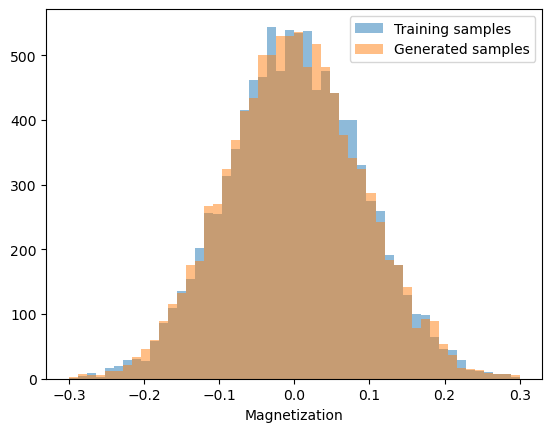

In [86]:
plt.hist(magnetization(training_samples).numpy(), range=(-0.3,0.3),
         alpha=0.5,bins=50,label='Training samples')
plt.hist(magnetization(generated_samples).numpy(), range=(-0.3,0.3),
         alpha=0.5,bins=50,label='Generated samples')
plt.legend()
plt.xlabel('Magnetization')
plt.show()

In [87]:
exp, var = jackknife(training_samples, magnetization_mean)
print('Magnetization:')
print('Training samples:',exp,'+-',var)

Magnetization:
Training samples: tensor(0.0014) +- tensor(0.0013)


In [88]:
exp, var = jackknife(generated_samples, magnetization_mean)
print('Generated samples:',exp,'+-',var)

Generated samples: tensor(-8.8619e-05) +- tensor(0.0013)


In [89]:
exp, var = jackknife(training_samples, susceptibility)
print('Susceptibility:')
print('Training samples:',exp,'+-',var)

Susceptibility:
Training samples: tensor(3.2424) +- tensor(0.0647)


In [90]:
exp, var = jackknife(generated_samples, susceptibility)
print('Generated samples:',exp,'+-',var)

Generated samples: tensor(3.2864) +- tensor(0.0660)


In [91]:
exp, var = jackknife(training_samples, binder_cumulant)
print('Binder cumulant:')
print('Training samples:',exp,'+-',var)

Binder cumulant:
Training samples: tensor(0.0115) +- tensor(0.0220)


In [92]:
exp, var = jackknife(generated_samples, binder_cumulant)
print('Generated samples:',exp,'+-',var)

Generated samples: tensor(-0.0117) +- tensor(0.0238)


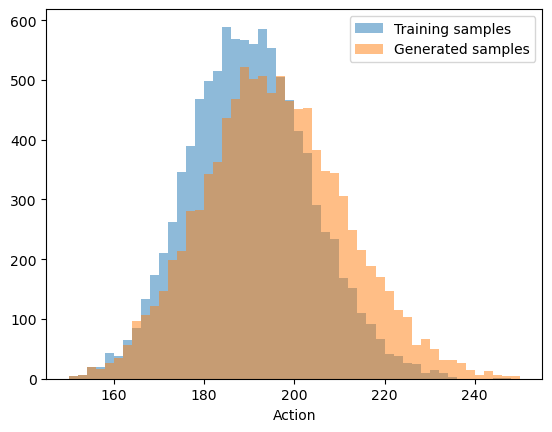

In [93]:
plt.hist(action(training_samples, kappa=0.22).numpy(), range=(150,250),
         alpha=0.5,bins=50,label='Training samples')
plt.hist(action(generated_samples, kappa=0.22).numpy(), range=(150,250),
         alpha=0.5,bins=50,label='Generated samples')
plt.legend()
plt.xlabel('Action')
plt.show()

## Flow

### Two point correlator

$$
\tilde{G}_2^{Carosso}(p_1,p_2) := \langle\tilde{\phi}(p_1)\tilde{\phi}(p_2)\rangle
$$

In [42]:
def two_point_corr(phi_p, p1, p2):
    # phi_p ... Batch of configurations, over which the expectation value is calculated
    # p1, p2 ... indices corresponding to the p values
    return torch.mean(phi_p[:,p1[0],p1[1]]*phi_p[:,p2[0],p2[1]])

$$
\tilde{G}_2^{Carosso}(p,-p) \approx \frac{Z}{|\hat{p}|^2 + r_t^2m_R^2} 
$$

In [43]:
def g_p_samples(samples, p):
    g = two_point_corr(fourier_transform(samples), [p[0],p[1]], [grid_size - 2 - p[0],grid_size - 2 - p[1]]).cpu()
    return g

### Renormalized mass

$$
\frac{1}{m_R^2} \approx \frac{r_t^2}{4 L^2} \sum_{p \in ((1,0),(0,1),(-1,0),(0,-1))} \frac{1}{\frac{4N^2}{L^2}\sin^2(\pi/N)}
\bigg( \frac{\tilde{G}_2^{Carosso}(0,0)}{\tilde{G}_2^{Carosso}(p,-p)} -1 \bigg)
$$

In [44]:
def renormalized_mass_times_rt_hist(g_hist_mean):
    # phi_p ... Batch of configurations, over which the expectation value is calculated
    
    term_1 = g_hist_mean[:,0] / g_hist_mean[:,1] - 1
    term_2 = g_hist_mean[:,0] / g_hist_mean[:,2] - 1

    corr_length = 1. / (4.) * 1. / (4. * grid_size**2 / L**2 * np.sin(np.pi/grid_size)**2) * 2. * (term_1 + term_2)
    return 1./corr_length

In [45]:
def fit_function(p_hat, Z, rm):
    return Z / (p_hat + rm)

In [46]:
def jackknife(dataset, observable_fct):
    n = dataset.shape[0]
    expectation_value = observable_fct(dataset)
    
    observables = np.zeros([n])
    for i in range(n):
        dataset = np.roll(dataset, -1, 0)
        dataset_i = dataset[:-2]
        observables[i] = observable_fct(dataset_i)
        
    variance = np.sum((observables - expectation_value)**2) * (n - 1.) / n
    std_dev = np.sqrt(variance)
    return expectation_value, std_dev

### Forward flow:

In [125]:
# Solving the forward SDE
def solve_sde_step(phi_0, t, dt):
    for i in range(int(t//dt)):
        phi_0 = (phi_0 + dt * drift_term(phi_0) + 
                 (grid_size / L) * np.sqrt(dt) * torch.randn(phi_0.shape, device=device))
    return phi_0

In [126]:
n_t = 21
dt = 2e-1
n_p = 5
n_iter = 200
t_points_flow = np.linspace(0, dt*(n_t-1), n_t)
g_hist_flow = np.zeros((n_t,n_iter,n_p))

p_hat_values = np.zeros((n_p,n_iter))

rm_hist_flow = np.zeros((n_t,2))
z_hist_flow = np.zeros((n_t,2))

for i in range(0,n_iter):
    p_hat_values[0,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([0.,0.])))**2,axis=-1)
    p_hat_values[1,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([1.,0.])))**2,axis=-1)
    p_hat_values[2,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([0.,1.])))**2,axis=-1)
    p_hat_values[3,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([2.,0.])))**2,axis=-1)
    p_hat_values[4,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([0.,2.])))**2,axis=-1)

p_0_index = grid_size//2 - 1

phi = torch.zeros((n_iter,5000,grid_size,grid_size))

for i in range(0,n_iter):
    phi[i] = training_samples[0:5000] / scale_factor
    g_hist_flow[0,i,0] = g_p_samples(phi[i].to(device), [p_0_index,p_0_index]).real.numpy()
    g_hist_flow[0,i,1] = g_p_samples(phi[i].to(device), [p_0_index+1,p_0_index]).real.numpy()
    g_hist_flow[0,i,2] = g_p_samples(phi[i].to(device), [p_0_index,p_0_index+1]).real.numpy()
    g_hist_flow[0,i,3] = g_p_samples(phi[i].to(device), [p_0_index+2,p_0_index]).real.numpy()
    g_hist_flow[0,i,4] = g_p_samples(phi[i].to(device), [p_0_index,p_0_index+2]).real.numpy()

def get_rm_curve_fit(g_hist_flow):
    return curve_fit(fit_function, np.array([p_hat_values.flatten()[i] for i in [0,n_iter,2*n_iter,3*n_iter,4*n_iter]]), 
                             np.mean(g_hist_flow, axis=0).flatten())[0][1]

def get_z_curve_fit(g_hist_flow):
    return curve_fit(fit_function, np.array([p_hat_values.flatten()[i] for i in [0,n_iter,2*n_iter,3*n_iter,4*n_iter]]), 
                             np.mean(g_hist_flow, axis=0).flatten())[0][0]


rm_hist_flow[0,0], rm_hist_flow[0,1] = jackknife(g_hist_flow[0], get_rm_curve_fit)
z_hist_flow[0,0], z_hist_flow[0,1] = jackknife(g_hist_flow[0], get_z_curve_fit)
    
print('time: ', dt*0)

for t in range(1,n_t):
    for i in range(0,n_iter):
        phi[i] = solve_sde_step(phi[i].to(device), dt, 5e-4).cpu()
        g_hist_flow[t,i,0] = g_p_samples(phi[i].to(device), [p_0_index,p_0_index]).real.numpy()
        g_hist_flow[t,i,1] = g_p_samples(phi[i].to(device), [p_0_index+1,p_0_index]).real.numpy()
        g_hist_flow[t,i,2] = g_p_samples(phi[i].to(device), [p_0_index,p_0_index+1]).real.numpy()
        g_hist_flow[t,i,3] = g_p_samples(phi[i].to(device), [p_0_index+2,p_0_index]).real.numpy()
        g_hist_flow[t,i,4] = g_p_samples(phi[i].to(device), [p_0_index,p_0_index+2]).real.numpy()
    
    rm_hist_flow[t,0], rm_hist_flow[t,1] = jackknife(g_hist_flow[t], get_rm_curve_fit)
    z_hist_flow[t,0], z_hist_flow[t,1] = jackknife(g_hist_flow[t], get_z_curve_fit)
    
    print('time: ', dt*t)

time:  0.0
time:  0.2
time:  0.4
time:  0.6000000000000001
time:  0.8
time:  1.0
time:  1.2000000000000002
time:  1.4000000000000001
time:  1.6
time:  1.8
time:  2.0
time:  2.2
time:  2.4000000000000004
time:  2.6
time:  2.8000000000000003
time:  3.0
time:  3.2
time:  3.4000000000000004
time:  3.6
time:  3.8000000000000003
time:  4.0


In [127]:
np.savez('theory_flow.npz', g_hist_flow = g_hist_flow, t_points_flow=t_points_flow, 
         rm_hist_flow=rm_hist_flow, z_hist_flow=z_hist_flow)

In [128]:
loading = np.load('theory_flow.npz')
g_hist_flow = loading['g_hist_flow']
t_points = loading['t_points_flow']
rm_hist_flow = loading['rm_hist_flow']
z_hist_flow = loading['z_hist_flow']

n_t = 21
dt = 2e-1
n_p = 5
n_iter = 200
t_points_flow = np.linspace(0, dt*(n_t-1), n_t)

In [129]:
g_hist_mean_flow = np.mean(g_hist_flow, axis=1)

In [130]:
def mean_g_hist_flow(g_hist_flow):
    return np.mean(g_hist_flow,axis=0)

In [131]:
g_00_hist_flow = np.zeros((n_t,2))
g_01_hist_flow = np.zeros((n_t,2))
g_10_hist_flow = np.zeros((n_t,2))
g_02_hist_flow = np.zeros((n_t,2))
g_20_hist_flow = np.zeros((n_t,2))
for i in range(n_t):
    g_00_hist_flow[i,0], g_00_hist_flow[i,1] = jackknife(g_hist_flow[i,:,0], mean_g_hist_flow)
    g_01_hist_flow[i,0], g_01_hist_flow[i,1] = jackknife(g_hist_flow[i,:,2], mean_g_hist_flow)
    g_10_hist_flow[i,0], g_10_hist_flow[i,1] = jackknife(g_hist_flow[i,:,1], mean_g_hist_flow)
    g_02_hist_flow[i,0], g_02_hist_flow[i,1] = jackknife(g_hist_flow[i,:,4], mean_g_hist_flow)
    g_20_hist_flow[i,0], g_20_hist_flow[i,1] = jackknife(g_hist_flow[i,:,3], mean_g_hist_flow)

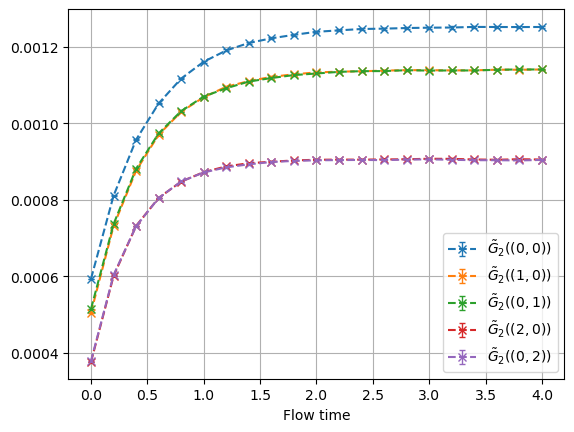

In [133]:
plt.errorbar(t_points_flow, g_00_hist_flow[:,0], yerr=g_00_hist_flow[:,1],
             fmt='--x', label=r'$\tilde{G}_2((0,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow, g_10_hist_flow[:,0], yerr=g_10_hist_flow[:,1],
             fmt='--x', label=r'$\tilde{G}_2((1,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow, g_01_hist_flow[:,0], yerr=g_01_hist_flow[:,1],
             fmt='--x', label=r'$\tilde{G}_2((0,1))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow, g_20_hist_flow[:,0], yerr=g_20_hist_flow[:,1],
             fmt='--x', label=r'$\tilde{G}_2((2,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow, g_02_hist_flow[:,0], yerr=g_02_hist_flow[:,1],
             fmt='--x', label=r'$\tilde{G}_2((0,2))$', elinewidth=1, capsize=2)
plt.grid()
plt.xlabel('Flow time')
plt.legend()
plt.show()

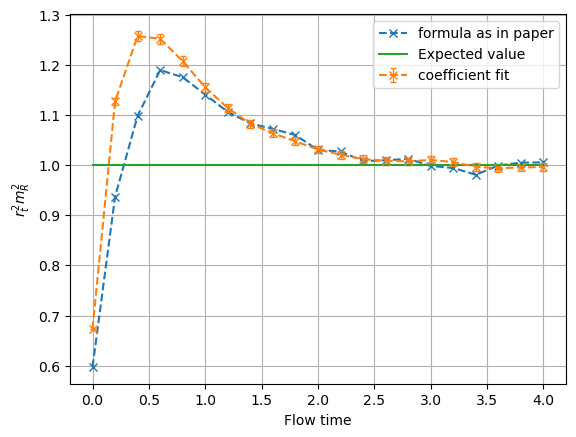

In [134]:
plt.plot(t_points_flow, renormalized_mass_times_rt_hist(g_hist_mean_flow),'--x', label='formula as in paper')
plt.errorbar(t_points_flow, rm_hist_flow[0:,0], yerr=rm_hist_flow[0:,1],
             fmt='--x', label='coefficient fit', elinewidth=1, capsize=2)
plt.plot(t_points_flow, np.ones(t_points_flow.shape[0])*m_squared.cpu().numpy(), label='Expected value')
plt.grid()
plt.xlabel('Flow time')
plt.ylabel(r'$r_t^2 m_R^2$')
plt.legend()
plt.show()

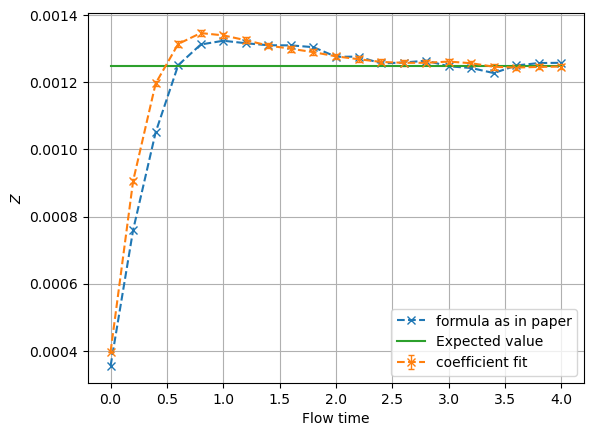

In [136]:
plt.plot(t_points_flow, (renormalized_mass_times_rt_hist(g_hist_mean_flow)*g_hist_mean_flow[:,0]),
         '--x', label='formula as in paper')
plt.errorbar(t_points_flow, z_hist_flow[0:,0], yerr=z_hist_flow[0:,1],
             fmt='--x', label='coefficient fit', elinewidth=1, capsize=2)
plt.plot(t_points_flow, np.ones(t_points_flow.shape[0])*(1./(2.*20.**2)), label='Expected value')

plt.grid()
plt.xlabel('Flow time')
plt.ylabel(r'$Z$')
plt.legend()
plt.show()

### Learned reverse flow:

In [47]:
def solve_ode_step(samples, t_start, t_end):
    solution = runge_kutta_4(samples, reverse_ode_func, step_size=-1e-3, t0=t_start, t1=t_end)
    return solution

In [48]:
n_t = 21
dt = 2e-1
n_p = 5
n_iter = 15
t_points_model = np.linspace(0, dt*(n_t-1), n_t)
g_hist_model = np.zeros((n_t,n_iter,n_p))

p_hat_values = np.zeros((n_p,n_iter))

rm_hist_model = np.zeros((n_t,2))
z_hist_model = np.zeros((n_t,2))

for i in range(0,n_iter):
    p_hat_values[0,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([0.,0.])))**2,axis=-1)
    p_hat_values[1,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([1.,0.])))**2,axis=-1)
    p_hat_values[2,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([0.,1.])))**2,axis=-1)
    p_hat_values[3,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([2.,0.])))**2,axis=-1)
    p_hat_values[4,i] = np.sum((2 * grid_size / L * np.sin(np.pi/grid_size * np.array([0.,2.])))**2,axis=-1)

p_0_index = grid_size//2 - 1

phi = torch.zeros((n_iter,1000,grid_size,grid_size))

for i in range(0,n_iter):
    phi[i] = draw_initial_config(1000)
    g_hist_model[-1,i,0] = g_p_samples(phi[i], [p_0_index,p_0_index]).real.numpy()
    g_hist_model[-1,i,1] = g_p_samples(phi[i], [p_0_index+1,p_0_index]).real.numpy()
    g_hist_model[-1,i,2] = g_p_samples(phi[i], [p_0_index,p_0_index+1]).real.numpy()
    g_hist_model[-1,i,3] = g_p_samples(phi[i], [p_0_index+2,p_0_index]).real.numpy()
    g_hist_model[-1,i,4] = g_p_samples(phi[i], [p_0_index,p_0_index+2]).real.numpy()
print('time: ', t_points_model[-1])

def get_rm_curve_fit(g_hist_model):
    return curve_fit(fit_function, np.array([p_hat_values.flatten()[i] for i in [0,n_iter,2*n_iter,3*n_iter,4*n_iter]]), 
                             np.mean(g_hist_model, axis=0).flatten())[0][1]

def get_z_curve_fit(g_hist_model):
    return curve_fit(fit_function, np.array([p_hat_values.flatten()[i] for i in [0,n_iter,2*n_iter,3*n_iter,4*n_iter]]), 
                             np.mean(g_hist_model, axis=0).flatten())[0][0]

rm_hist_model[-1,0], rm_hist_model[-1,1] = jackknife(g_hist_model[-1], get_rm_curve_fit)
z_hist_model[-1,0], z_hist_model[-1,1] = jackknife(g_hist_model[-1], get_z_curve_fit)


for t in range(1,n_t):
    for i in range(0,n_iter):
        phi[i] = solve_ode_step(phi[i].to(device), t_start=t_points_model[-t] ,t_end=t_points_model[-t-1]).cpu()
        g_hist_model[-t-1,i,0] = g_p_samples(phi[i], [p_0_index,p_0_index]).real.numpy()
        g_hist_model[-t-1,i,1] = g_p_samples(phi[i], [p_0_index+1,p_0_index]).real.numpy()
        g_hist_model[-t-1,i,2] = g_p_samples(phi[i], [p_0_index,p_0_index+1]).real.numpy()
        g_hist_model[-t-1,i,3] = g_p_samples(phi[i], [p_0_index+2,p_0_index]).real.numpy()
        g_hist_model[-t-1,i,4] = g_p_samples(phi[i], [p_0_index,p_0_index+2]).real.numpy()
    
    rm_hist_model[-t-1,0], rm_hist_model[-t-1,1] = jackknife(g_hist_model[-t-1], get_rm_curve_fit)
    z_hist_model[-t-1,0], z_hist_model[-t-1,1] = jackknife(g_hist_model[-t-1], get_z_curve_fit)
        
    print('time: ', t_points_model[-t-1])

time:  4.0
time:  3.8000000000000003
time:  3.6
time:  3.4000000000000004
time:  3.2
time:  3.0
time:  2.8000000000000003
time:  2.6
time:  2.4000000000000004
time:  2.2
time:  2.0
time:  1.8
time:  1.6
time:  1.4000000000000001
time:  1.2000000000000002
time:  1.0
time:  0.8
time:  0.6000000000000001
time:  0.4
time:  0.2
time:  0.0


In [101]:
np.savez('model_flow.npz', g_hist_model = g_hist_model, t_points_model=t_points_model,
        rm_hist_model=rm_hist_model, z_hist_model=z_hist_model)

In [102]:
loading = np.load('model_flow.npz')
g_hist_model = loading['g_hist_model']
t_points_model = loading['t_points_model']
rm_hist_model = loading['rm_hist_model']
z_hist_model = loading['z_hist_model']

In [49]:
g_hist_mean_model = np.mean(g_hist_model, axis=1)

In [50]:
def mean_g_hist_model(g_hist_model):
    return np.mean(g_hist_model,axis=0)

In [51]:
g_00_hist_model = np.zeros((n_t,2))
g_01_hist_model = np.zeros((n_t,2))
g_10_hist_model = np.zeros((n_t,2))
g_02_hist_model = np.zeros((n_t,2))
g_20_hist_model = np.zeros((n_t,2))
for i in range(n_t):
    g_00_hist_model[i,0], g_00_hist_model[i,1] = jackknife(g_hist_model[i,:,0], mean_g_hist_model)
    g_01_hist_model[i,0], g_01_hist_model[i,1] = jackknife(g_hist_model[i,:,2], mean_g_hist_model)
    g_10_hist_model[i,0], g_10_hist_model[i,1] = jackknife(g_hist_model[i,:,1], mean_g_hist_model)
    g_02_hist_model[i,0], g_02_hist_model[i,1] = jackknife(g_hist_model[i,:,4], mean_g_hist_model)
    g_20_hist_model[i,0], g_20_hist_model[i,1] = jackknife(g_hist_model[i,:,3], mean_g_hist_model)

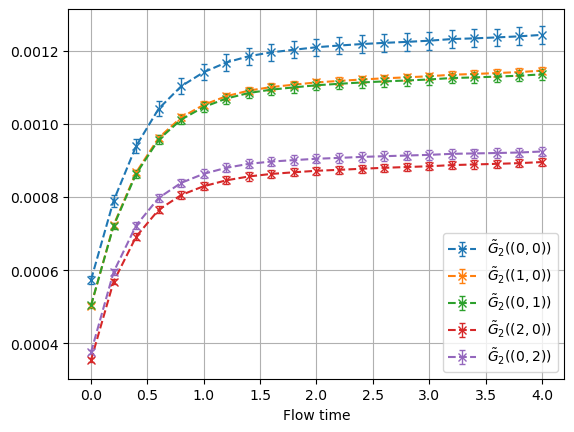

In [111]:
plt.errorbar(t_points_model, g_00_hist_model[:,0], yerr=g_00_hist_model[:,1],
             fmt='--x', label=r'$\tilde{G}_2((0,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_model, g_10_hist_model[:,0], yerr=g_10_hist_model[:,1],
             fmt='--x', label=r'$\tilde{G}_2((1,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_model, g_01_hist_model[:,0], yerr=g_01_hist_model[:,1],
             fmt='--x', label=r'$\tilde{G}_2((0,1))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_model, g_20_hist_model[:,0], yerr=g_20_hist_model[:,1],
             fmt='--x', label=r'$\tilde{G}_2((2,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_model, g_02_hist_model[:,0], yerr=g_02_hist_model[:,1],
             fmt='--x', label=r'$\tilde{G}_2((0,2))$', elinewidth=1, capsize=2)
plt.grid()
plt.xlabel('Flow time')
plt.legend()
plt.show()

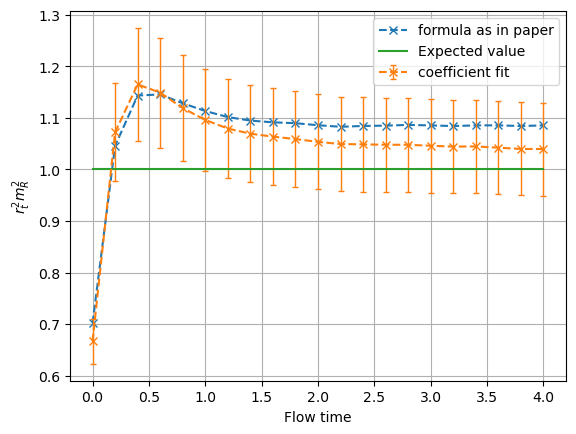

In [108]:
plt.plot(t_points_model[0:], renormalized_mass_times_rt_hist(g_hist_mean_model)[0:],'--x', label='formula as in paper')
plt.errorbar(t_points_model[0:], rm_hist_model[0:,0], yerr=rm_hist_model[0:,1],
             fmt='--x', label='coefficient fit', elinewidth=1, capsize=2)
plt.plot(t_points_model[0:], np.ones(t_points_model.shape[0])*m_squared.cpu().numpy(), label='Expected value')
plt.grid()
plt.xlabel('Flow time')
plt.ylabel(r'$r_t^2 m_R^2$')
plt.legend()
plt.show()

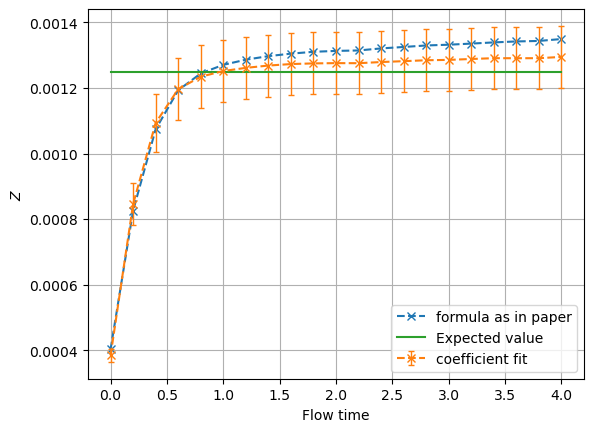

In [109]:
plt.plot(t_points_model[0:], (renormalized_mass_times_rt_hist(g_hist_mean_model)*g_hist_mean_model[:,0])[0:],
         '--x', label='formula as in paper')
plt.errorbar(t_points_model[0:], z_hist_model[0:,0], yerr=z_hist_model[0:,1],
             fmt='--x', label='coefficient fit', elinewidth=1, capsize=2)
plt.plot(t_points_model[0:], np.ones(t_points_model.shape[0])*(1./(2.*20.**2)), label='Expected value')

plt.grid()
plt.xlabel('Flow time')
plt.ylabel(r'$Z$')
plt.legend()
plt.show()

### Comparison

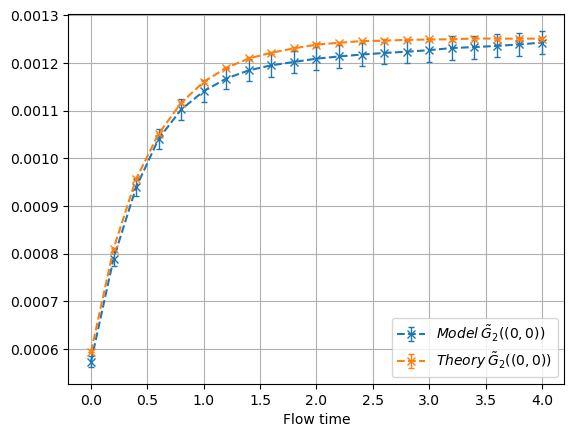

In [137]:
plt.errorbar(t_points_model[0:], g_00_hist_model[:,0], yerr=g_00_hist_model[:,1],
             fmt='--x', label=r'$Model\: \tilde{G}_2((0,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow[0:], g_00_hist_flow[:,0], yerr=g_00_hist_flow[:,1],
             fmt='--x', label=r'$Theory\: \tilde{G}_2((0,0))$', elinewidth=1, capsize=2)
plt.grid()
plt.xlabel('Flow time')
plt.legend()
plt.show()

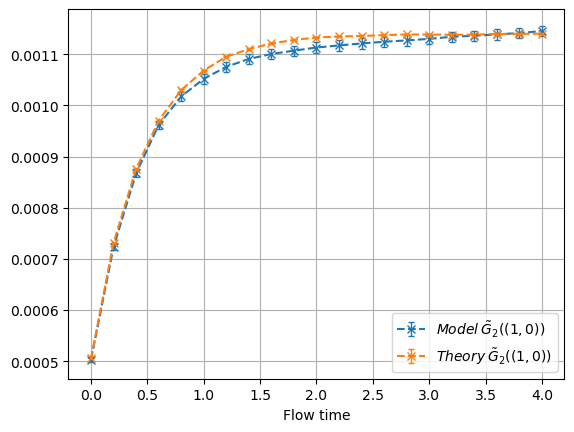

In [138]:
plt.errorbar(t_points_model[0:], g_10_hist_model[:,0], yerr=g_10_hist_model[:,1],
             fmt='--x', label=r'$Model\: \tilde{G}_2((1,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow[0:], g_10_hist_flow[:,0], yerr=g_10_hist_flow[:,1],
             fmt='--x', label=r'$Theory\: \tilde{G}_2((1,0))$', elinewidth=1, capsize=2)
plt.grid()
plt.xlabel('Flow time')
plt.legend()
plt.show()

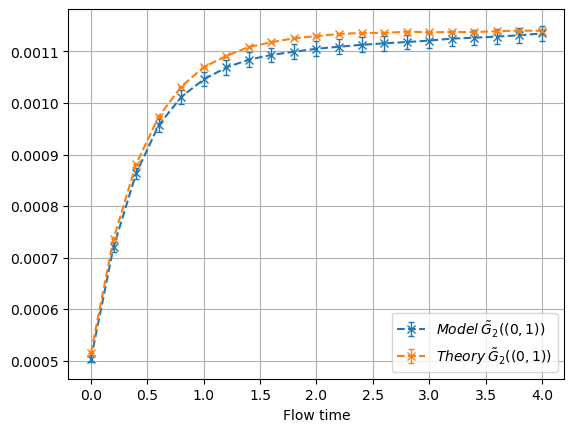

In [139]:
plt.errorbar(t_points_model[0:], g_01_hist_model[:,0], yerr=g_01_hist_model[:,1],
             fmt='--x', label=r'$Model\: \tilde{G}_2((0,1))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow[0:], g_01_hist_flow[:,0], yerr=g_01_hist_flow[:,1],
             fmt='--x', label=r'$Theory\: \tilde{G}_2((0,1))$', elinewidth=1, capsize=2)
plt.grid()
plt.xlabel('Flow time')
plt.legend()
plt.show()

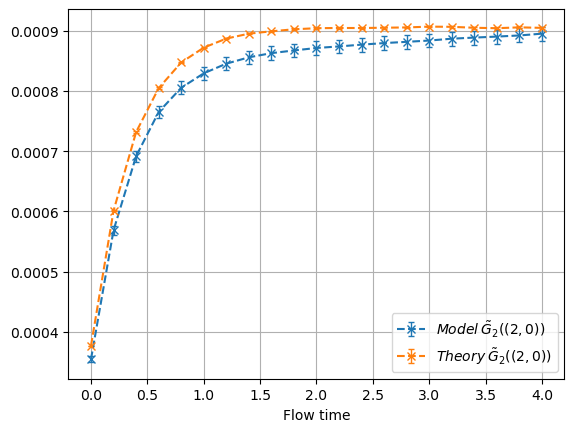

In [140]:
plt.errorbar(t_points_model[0:], g_20_hist_model[:,0], yerr=g_20_hist_model[:,1],
             fmt='--x', label=r'$Model\: \tilde{G}_2((2,0))$', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow[0:], g_20_hist_flow[:,0], yerr=g_20_hist_flow[:,1],
             fmt='--x', label=r'$Theory\: \tilde{G}_2((2,0))$', elinewidth=1, capsize=2)
plt.grid()
plt.xlabel('Flow time')
plt.legend()
plt.show()

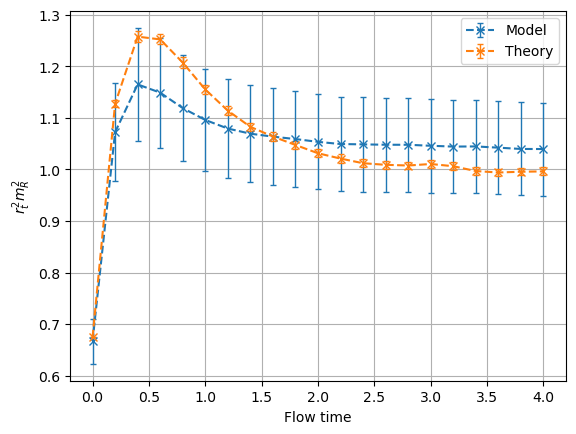

In [141]:
plt.errorbar(t_points_model[0:], rm_hist_model[0:,0], yerr=rm_hist_model[0:,1],
             fmt='--x', label='Model', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow[0:], rm_hist_flow[0:,0], yerr=rm_hist_flow[0:,1],
             fmt='--x', label='Theory', elinewidth=1, capsize=2)
plt.grid()
plt.xlabel('Flow time')
plt.ylabel(r'$r_t^2 m_R^2$')
plt.legend()
plt.show()

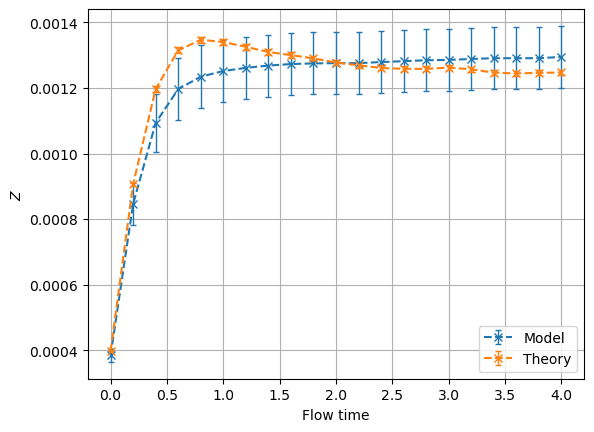

In [142]:
plt.errorbar(t_points_model[0:], z_hist_model[0:,0], yerr=z_hist_model[0:,1],
             fmt='--x', label='Model', elinewidth=1, capsize=2)
plt.errorbar(t_points_flow[0:], z_hist_flow[0:,0], yerr=z_hist_flow[0:,1],
             fmt='--x', label='Theory', elinewidth=1, capsize=2)
plt.grid()
plt.xlabel('Flow time')
plt.ylabel(r'$Z$')
plt.legend()
plt.show()